# Predicting Whether a NFL Play is a Run or a Pass

### Contents

Topic of Analysis<br>
Background<br>
Summary of Findings<br>
Setup: Import Libraries and Data<br>
Data Pre-processing<br>
Training the Model<br>
Scoring the Model<br>
Optimizing the Model<br>
Top 5 Predictive Features<br>
Conclusion & Next Steps<br>
Appendix

### Topic of Analysis

How effective are ML algorithms at predicting whether a play will be a run or a pass?

### Background

While browsing online for open football datasets, I came across a really interesting one on data.world ([1]) . For each row within this dataset, there is an offensive play detailing information such as where each play took place on the field, what down it was, how many yards to go, and whether it was a pass or run. 

Often times when I am watching football, I find myself predicting whether or not the next play is going to be a run or a pass. And while I don't actually track how successful I am at these predictions, I started to wonder if I could apply some of my newly acquired Machine Learning knowledge and use an algorithm to predict whether or not a particular play was a pass or not.

So, the objective of this analysis is to see how accurate a ML algorithm is at predicting whether or not the play in question is a Pass or a Run.

This is going to be fun! So let's do this!

----

[1]: https://data.world/bpovlins/nfl-play-by-play-data/workspace/file?filename=2016+NFL+Play-by-Play+Data.xlsx

### Summary of Findings

Using a DecisionTree Algorithm from sklearn, an unoptimized ML model successfully predicted that a play in question was a Pass or a Run 65% of the time! If you were to only guess passing downs for every play, you would be correct 59% of the time given that is the proportion of passes for the 2016 season. The algorithm improves on that baseline by 10%. 

Further hyper-parameter optimizations using Grid Search improved the accuracy score of the model by 2 points to 67%. 

The top 5 most predictive features when determining whether or not a play is a pass or a run include: <br>

1) Down Distance to First Down <br>
2) Down <br>
3) Time remaining on the clock <br>
4) Opponents Score <br>
5) Quarter. <br>

### Import Libraries & Data

Let's import all of the libraries we will need to conduct this analysis and train a ML model. 

In [1]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # Split the data to test
from sklearn.tree import DecisionTreeClassifier # The ML Model used
from sklearn.metrics import accuracy_score # Score the accuracy of the predictions
from sklearn.model_selection import GridSearchCV # Grid Search helps us tweak the parameters to optimize the model
from sklearn.metrics import make_scorer, f1_score # Score the optimized model
import matplotlib.pyplot as plt # for any data viz
import visuals as vs # supplementary visualization code visuals.py
% matplotlib inline

In [2]:
# import 2016 play by play data
df = pd.read_excel('https://query.data.world/s/yvnrhj3w64lfrxccu6ezatp2zuqw3n')

#### Data Exploration

In [3]:
# Let's set the viewing option so that we can see all of the columns when using commands like .head()
pd.set_option('display.max_columns', 68)

In [4]:
# let's see the head of the data
df.head()

,Date,Tm,Opp,Quarter,Time,Down,ToGo,Side of Field,Yard Marker,Tm Score,Opp Score,Detail,Yds,Play Type,Pass Result,Pass Distance,Pass Location,Run Location,Turnover,Fumble,Interception,Passer,Intended Receiver,Receiver,Targeted Receiver,Rusher,Touchdown,First Down,Time Under,Score Differential,Absolute Score Differential,Game Week,Team Game Location,Rush Attempt,Pass Attempt,Reception,Interception Thrown,Target,Fumble Count,Sack,Len,Yard Line,Playmaker,Touches,Play Attempts,Playmaker Position,Yards Gained,Play Location,Touchdown Count,Play Percent of Goal,First Down Count,Conversion Count,Goal To Go,Success Count,Penalty Removed Detail,Len Penalty,Playmaker Fantasy Points,Passer Fantasy Points,Fantasy Points Rushing Yards,Fantasy Points Receiving Yards,Fantasy Points Receptions,Fantasy Points Rushing TD,Fantasy Points Receiving TD,Fantasy Points Playmaker Fumble,Fantasy Points Passer Yards,Fantasy Points Passer TD,Fantasy Points Passer Interception,Team Game #
0,2016-09-11,Falcons,Buccaneers,1,09:52:00,1,10,ATL,25,0,3,Matt Ryan pass complete deep right to Mohamed ...,59.0,Pass,Complete,Deep,Right,NaN,0,NaN,NaN,Matt Ryan,NaN,Mohamed Sanu,Mohamed Sanu,NaN,NaN,First Down,10,-3,3,1,home,0,1,1,0,1,0,0,87,75,Mohamed Sanu,1,1,WR,59,Deep Right,0,5.9,1,1,0,1,Matt Ryan pass complete deep right to Mohamed ...,87,6.4,2.36,0.0,5.9,0.5,0,0,0,2.36,0,0,1
1,2016-09-11,Cardinals,Patriots,1,07:29:00,1,10,CRD,11,0,7,Carson Palmer pass complete deep left to Micha...,39.0,Pass,Complete,Deep,Left,NaN,0,NaN,NaN,Carson Palmer,NaN,Michael Floyd,Michael Floyd,NaN,NaN,First Down,8,-7,7,1,home,0,1,1,0,1,0,0,67,89,Michael Floyd,1,1,WR,39,Deep Left,0,3.9,1,1,0,1,Carson Palmer pass complete deep left to Micha...,67,4.4,1.56,0.0,3.9,0.5,0,0,0,1.56,0,0,1
2,2016-09-11,Jaguars,Packers,1,05:04:00,1,10,GNB,48,0,7,Blake Bortles pass complete short left to Marc...,37.0,Pass,Complete,Short,Left,NaN,0,NaN,NaN,Blake Bortles,NaN,Marcedes Lewis,Marcedes Lewis,NaN,NaN,First Down,6,-7,7,1,home,0,1,1,0,1,0,0,99,48,Marcedes Lewis,1,1,TE,37,Short Left,0,3.7,1,1,0,1,Blake Bortles pass complete short left to Marc...,99,4.2,1.48,0.0,3.7,0.5,0,0,0,1.48,0,0,1
3,2016-09-11,Raiders,Saints,1,04:03:00,1,10,RAI,20,3,3,Derek Carr pass complete short middle to Amari...,35.0,Pass,Complete,Short,Middle,NaN,0,NaN,NaN,Derek Carr,NaN,Amari Cooper,Amari Cooper,NaN,NaN,First Down,5,0,0,1,away,0,1,1,0,1,0,0,92,80,Amari Cooper,1,1,WR,35,Short Middle,0,3.5,1,1,0,1,Derek Carr pass complete short middle to Amari...,92,4.0,1.40,0.0,3.5,0.5,0,0,0,1.40,0,0,1
4,2016-09-11,Bears,Texans,1,08:36:00,1,10,HTX,49,0,0,Jay Cutler pass complete deep left to Alshon J...,29.0,Pass,Complete,Deep,Left,NaN,0,NaN,NaN,Jay Cutler,NaN,Alshon Jeffery,Alshon Jeffery,NaN,NaN,First Down,9,0,0,1,away,0,1,1,0,1,0,0,91,49,Alshon Jeffery,1,1,WR,29,Deep Left,0,2.9,1,1,0,1,Jay Cutler pass complete deep left to Alshon J...,91,3.4,1.16,0.0,2.9,0.5,0,0,0,1.16,0,0,1


In [5]:
# Schema
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33211 entries, 0 to 33210
Data columns (total 68 columns):
Date                                   33211 non-null datetime64[ns]
Tm                                     33211 non-null object
Opp                                    33211 non-null object
Quarter                                33211 non-null int64
Time                                   33211 non-null object
Down                                   33211 non-null int64
ToGo                                   33211 non-null int64
Side of Field                          33211 non-null object
Yard Marker                            33211 non-null int64
Tm Score                               33211 non-null int64
Opp Score                              33211 non-null int64
Detail                                 33211 non-null object
Yds                                    26048 non-null float64
Play Type                              33211 non-null object
Pass Result                       

### Data Pre-Processing

Data cleansing and set up will involve the following:

1. Strip spaces and set column headers to Lowercase
2. We will convert the quarter game clock from 15:00 to seconds remaining (eg. 15 min = 900)
3. Create a new df with select columns to test on
4. Find and Replace (using map) to set plays of Pass to 0 and Run to 1

#### 1. Strip Spaces and Set Columns to Lowercase

In [6]:
# Let's remove all the spaces and set the column titles to lowercase
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

#### 2. Convert the quarter game clock to seconds remaining

In [7]:
# Let's split time into seconds remaining in the quarter
df['time_mod'] = df['time'].astype(str)

In [8]:
# Split the game clock into 3 columns minutes, seconds and nothing (to be dropped)
df['minutes'], df['seconds'],df['nothing'] = df['time_mod'].str.split(':', 2).str

In [9]:
# Strip out the leading 0's from minutes and seconds (eg. 01 becomes 1)
df['minutes'] = df['minutes'].str.lstrip('0')
df['seconds'] = df['seconds'].str.lstrip('0')

In [10]:
# Convert Strings to a Number
df['minutes'] = pd.to_numeric(df.minutes, errors='coerce')
df['seconds'] = pd.to_numeric(df.seconds, errors='coerce')

In [12]:
# Formula to convert total time remining on the game clock to seconds remaining
df['seconds_remaining'] = (df['minutes']*60)+df['seconds']

#### 3. Create a new df for the test

In [14]:
# Let's create a new df with a few columns selected
df_new = df.filter(['tm','opp', 'quarter','seconds_remaining','down','togo', 'side_of_field','yard_marker','tm_score','opp_score','absolute_score_differential','game_week','play_type'], axis=1)

In [15]:
df_new.head()

,tm,opp,quarter,seconds_remaining,down,togo,side_of_field,yard_marker,tm_score,opp_score,absolute_score_differential,game_week,play_type
0,Falcons,Buccaneers,1,592.0,1,10,ATL,25,0,3,3,1,Pass
1,Cardinals,Patriots,1,449.0,1,10,CRD,11,0,7,7,1,Pass
2,Jaguars,Packers,1,304.0,1,10,GNB,48,0,7,7,1,Pass
3,Raiders,Saints,1,243.0,1,10,RAI,20,3,3,0,1,Pass
4,Bears,Texans,1,516.0,1,10,HTX,49,0,0,0,1,Pass


#### 4. Set Pass to 1 and Run to 0

In [18]:
df_new['outcome'] = df_new.play_type.map({'Pass':1, 'Run':0})

In [19]:
df_new.head()

,tm,opp,quarter,seconds_remaining,down,togo,side_of_field,yard_marker,tm_score,opp_score,absolute_score_differential,game_week,play_type,outcome
0,Falcons,Buccaneers,1,592.0,1,10,ATL,25,0,3,3,1,Pass,1
1,Cardinals,Patriots,1,449.0,1,10,CRD,11,0,7,7,1,Pass,1
2,Jaguars,Packers,1,304.0,1,10,GNB,48,0,7,7,1,Pass,1
3,Raiders,Saints,1,243.0,1,10,RAI,20,3,3,0,1,Pass,1
4,Bears,Texans,1,516.0,1,10,HTX,49,0,0,0,1,Pass,1


### Split the Data

Now let's split the data into outcomes (which we are trying to predict) and features.

In [20]:
# Store the 'outcome' (Pass or Run) feature in a new variable and remove it from the dataset
outcomes = df_new['outcome']
features_raw = df_new.drop(['outcome','play_type'], axis = 1)

In [20]:
features_raw.head()

,date,tm,opp,quarter,time,down,togo,side_of_field,yard_marker,tm_score,opp_score
0,2016-09-11,Falcons,Buccaneers,1,09:52:00,1,10,ATL,25,0,3
1,2016-09-11,Cardinals,Patriots,1,07:29:00,1,10,CRD,11,0,7
2,2016-09-11,Jaguars,Packers,1,05:04:00,1,10,GNB,48,0,7
3,2016-09-11,Raiders,Saints,1,04:03:00,1,10,RAI,20,3,3
4,2016-09-11,Bears,Texans,1,08:36:00,1,10,HTX,49,0,0


#### Turn the features into Dummies

In [21]:
# Get Dummies
features = pd.get_dummies(features_raw)

In [22]:
features = features.fillna(0.0)

In [29]:
features.head()

,quarter,seconds_remaining,down,togo,yard_marker,tm_score,opp_score,absolute_score_differential,game_week,tm_49ers,tm_Bears,tm_Bengals,tm_Bills,tm_Broncos,tm_Browns,tm_Buccaneers,tm_Cardinals,tm_Chargers,tm_Chiefs,tm_Colts,tm_Cowboys,tm_Dolphins,tm_Eagles,tm_Falcons,tm_Giants,tm_Jaguars,tm_Jets,tm_Lions,tm_Packers,tm_Panthers,tm_Patriots,tm_Raiders,tm_Rams,tm_Ravens,...,opp_Vikings,side_of_field_ATL,side_of_field_BUF,side_of_field_CAR,side_of_field_CHI,side_of_field_CIN,side_of_field_CLE,side_of_field_CLT,side_of_field_CRD,side_of_field_DAL,side_of_field_DEN,side_of_field_DET,side_of_field_GNB,side_of_field_HTX,side_of_field_JAX,side_of_field_KAN,side_of_field_MIA,side_of_field_MIN,side_of_field_NOR,side_of_field_NWE,side_of_field_NYG,side_of_field_NYJ,side_of_field_OTI,side_of_field_PHI,side_of_field_PIT,side_of_field_RAI,side_of_field_RAM,side_of_field_RAV,side_of_field_SDG,side_of_field_SEA,side_of_field_SFO,side_of_field_TAM,side_of_field_The,side_of_field_WAS
0,1,592.0,1,10,25,0,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,449.0,1,10,11,0,7,7,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,304.0,1,10,48,0,7,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,243.0,1,10,20,3,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,1,516.0,1,10,49,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Train the Model

In [23]:
# Split the model into train / test
X_train, X_test, y_train, y_test = train_test_split(features, outcomes, test_size=0.2, random_state=42)

In [24]:
# Let's use a Decision Tree and fit the model.
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Testing the model
Now, let's see how our model does, let's calculate the accuracy over both the training and the testing set.

In [25]:
# Making predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate the accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Output
print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)

The training accuracy is 0.9996612466124661
The test accuracy is 0.6482011139545386


### Optimize the Model

Let's see if we can optimize our model to get a better prediction by tuning the hyper-parameters. 

In [37]:
# The parameters to tune.
parameters = {'max_depth':[2,4,6,8,10],'min_samples_leaf':[2,4,6,8,10], 'min_samples_split':[2,4,6,8,10]}

# Make an f1_score scoring object.
scorer = make_scorer(f1_score)

# Perform grid search on the classifier using 'scorer' as the scoring method.
grid_obj = GridSearchCV(model, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters.
grid_fit = grid_obj.fit(X_train, y_train)

# Get the best model using best_estimator_.
best_model = grid_fit.best_estimator_

# Fit the best model.
best_model.fit(X_train, y_train)

# Make predictions using the best model.
best_train_predictions = best_model.predict(X_train)
best_test_predictions = best_model.predict(X_test)

# Calculate score of the best performing model.
print('The training F1 Score is', f1_score(best_train_predictions, y_train))
print('The testing F1 Score is', f1_score(best_test_predictions, y_test))
print('The optimized accuracy score is', accuracy_score(y_test, best_test_predictions))

# Output of the parameters being used in the best model.
best_model

The training F1 Score is 0.7142420226322763
The testing F1 Score is 0.7046492878258532
The optimized accuracy score is 0.6691253951527925


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=6,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Feature Extraction

Let's use feature extraction to see what are the top 5 predicitive features used to determine whether or not the play is a Pass or a Run.

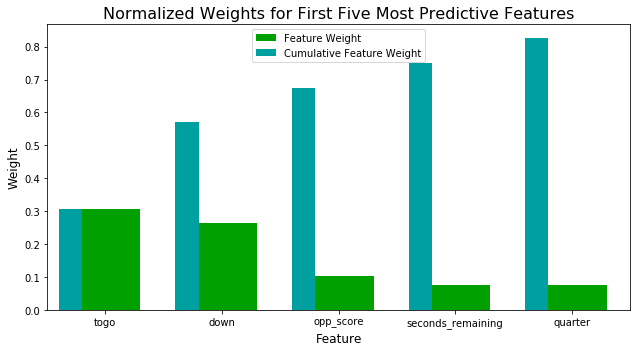

In [38]:
# Extract the feature importances using .feature_importances_ 
importances = best_model.feature_importances_

# Plot the top 5 most predictive features data
vs.feature_plot(importances, X_train, y_train)

### Conclusion & Next Steps

Overall, this was a fun excercise to see if I could use machine learning to determine how accurate a model could predict whether or not a given play was a pass or a run. It was interesting to see that the algorithm successfully predicted the scenerio 67% of the time. 

The top 5 most predictive features when determining whether or not a play is a pass or a run include:

1) Down Distance to First Down<br>
2) Down<br>
3) Time remaining on the clock<br>
4) Opponents Score<br>
5) Quarter<br>

#### Next Steps

Future analysis considerations should include:

- Build out functions to test additional models such as Random Forest.
- Segment the data to see how predictions perform on specific scenerios (eg. redzone)
- Create a scenerio calculator to explore how teams play in different situations. 
- Conduct a QB analysis around specific scenerios.

#### Questions?

If you have any feedback, I would love to hear it! Please reach out to me at mail AT garethcull.com. Thanks!

### Appendix

In [35]:
df.groupby('play_type').count()

,date,tm,opp,quarter,time,down,togo,side_of_field,yard_marker,tm_score,opp_score,detail,yds,pass_result,pass_distance,pass_location,run_location,turnover,fumble,interception,passer,intended_receiver,receiver,targeted_receiver,rusher,touchdown,first_down,time_under,score_differential,absolute_score_differential,game_week,team_game_location,rush_attempt,pass_attempt,...,sack,len,yard_line,playmaker,touches,play_attempts,playmaker_position,yards_gained,play_location,touchdown_count,play_percent_of_goal,first_down_count,conversion_count,goal_to_go,success_count,penalty_removed_detail,len_penalty,playmaker_fantasy_points,passer_fantasy_points,fantasy_points_rushing_yards,fantasy_points_receiving_yards,fantasy_points_receptions,fantasy_points_rushing_td,fantasy_points_receiving_td,fantasy_points_playmaker_fumble,fantasy_points_passer_yards,fantasy_points_passer_td,fantasy_points_passer_interception,team_game_#,time_mod,minutes,seconds,nothing,seconds_remaining
play_type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Pass,19348,19348,19348,19348,19348,19348,19348,19348,19348,19348,19348,19348,12202,19348,19348,19348,0,19348,144,440,19348,6870,12213,19083,0,820,5957,19348,19348,19348,19348,19348,19348,19348,...,19348,19348,19348,19083,19348,19348,18870,19348,19348,19348,19348,19348,19348,19348,19348,19348,19348,19348,19348,19348,19348,19348,19348,19348,19348,19348,19348,19348,19348,19348,17399,18421,19348,16477
Run,13863,13863,13863,13863,13863,13863,13863,13863,13863,13863,13863,13863,13846,1245,0,0,13863,13863,253,0,0,0,0,0,13776,478,2793,13863,13863,13863,13863,13863,13863,13863,...,13863,13863,13863,13776,13863,13863,13219,13863,13863,13863,13863,13863,13863,13863,13863,13863,13863,13863,13863,13863,13863,13863,13863,13863,13863,13863,13863,13863,13863,13863,13096,13133,13863,12367
